In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [14]:
pca_data = pd.read_csv("cpa_data.csv")
pca_data.head()


,fecha,referencia,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,06/04/01,P1,-2.172840,-0.521445,-0.444831,-0.162855,-0.399744,-0.048975,-0.092430,-0.233617,-0.031675,0.210330
1,06/04/01,P2,-1.989673,-0.561169,0.142021,0.416451,-0.991852,0.092949,0.053050,0.800244,-0.385982,-0.617666
2,06/04/01,P3,-2.154176,-0.100730,-0.214204,0.996446,0.892430,0.249675,-0.490614,-0.794934,0.128861,1.030285
3,06/04/01,P4,-2.238051,-0.316221,-1.208847,-0.959316,-0.314796,-0.046410,0.342104,-0.369822,0.130015,0.186329
4,07/04/01,P1,-2.375187,-0.322874,-0.971796,-0.991752,-0.346266,-0.070763,0.227969,-0.403109,0.282735,0.107680


## Entrenamiento para clasificación con K-Means

Para realizar un entrenamiento no supervisado con una base de datos de parámetros químicos, la mejor opción es utilizar un Mapa Auto-Organizado (SOM) o un Autoencoder. Sin embargo, dado que ya tienes los Componentes Principales (PCA), la técnica más robusta y estándar para encontrar grupos (clusters) es el K-Means Clustering potenciado por una Red Neuronal para validación.

### Preparación de los datos (Inputs del PCA)

Usaremos los componentes que explican la mayor parte de la varianza (según tu tabla, los primeros 5 o 6 son los más informativos).

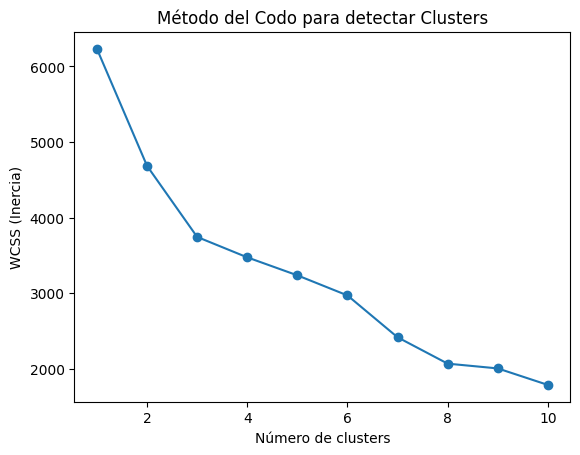

In [15]:
# Usamos los resultados del PCA (asumiendo que df_pca tiene tus componentes)
# Seleccionamos, por ejemplo, los primeros 5 componentes principales
X_unsupervised = pca_data.iloc[:, 2:8] 

# Determinamos el número óptimo de clusters (Método del Codo)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_unsupervised)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo para detectar Clusters')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS (Inercia)')
plt.show()

### Entrenamiento del Modelo de Clasificación

Una vez identificado el número de grupos (supongamos que el "codo" está en 3 o 4 clusters), ejecutamos el entrenamiento final.

In [24]:
# Entrenamos con el número de clusters elegido (ejemplo: 4)
n_clusters_optimo = 4
model = KMeans(n_clusters=n_clusters_optimo, init='k-means++', random_state=42)
clusters = model.fit_predict(X_unsupervised)

# Añadimos la clasificación a nuestro DataFrame original
# data_fixed['cluster_id'] = clusters

### Gráfico de Dispersión 2D (Visualización Estándar)

Primero, asegúrate de tener en un solo lugar los componentes y las etiquetas de los clusters que generó el modelo.

In [ ]:
# Creamos un DataFrame auxiliar para graficar
cp_grafico = ['PC1', 'PC3']
df_grafico = pca_data[cp_grafico].copy()
df_grafico['Cluster'] = clusters # Las etiquetas que generó tu modelo K-Means

# Agregamos una columna de texto para que la leyenda sea más clara
df_grafico['Cluster_Name'] = df_grafico['Cluster'].apply(lambda x: f'Grupo {x}')


Este gráfico te permitirá ver cómo el algoritmo separó las muestras de agua. Si los grupos están bien definidos, verás "nubes" de puntos de distintos colores.

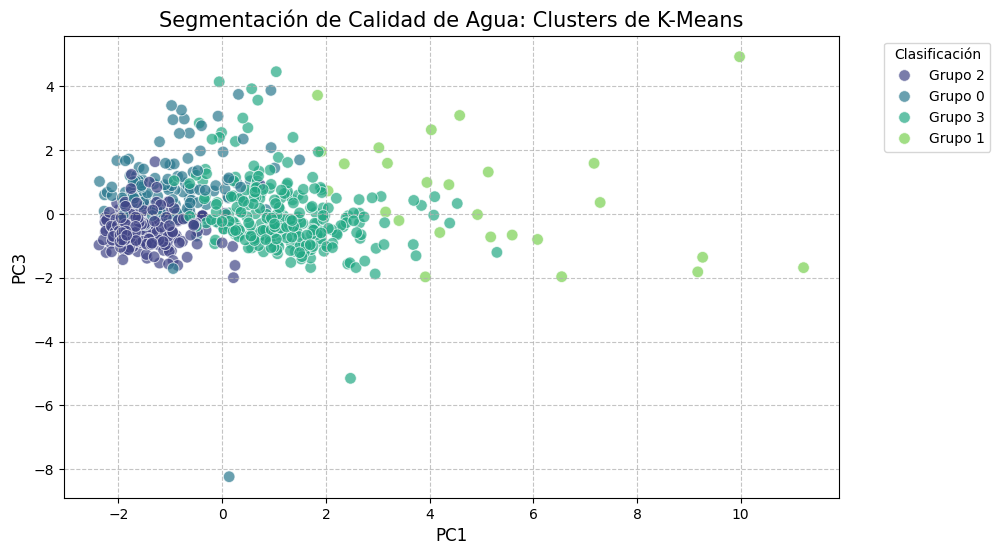

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grafico, 
    x=cp_grafico[0], 
    y=cp_grafico[1], 
    hue='Cluster_Name', 
    palette='viridis', 
    s=70, 
    alpha=0.7,
    edgecolor='w'
)

# Personalización de títulos (basado en tu interpretación de loadings)
plt.title('Segmentación de Calidad de Agua: Clusters de K-Means', fontsize=15)
plt.xlabel(f'{cp_grafico[0]}', fontsize=12)
plt.ylabel(f'{cp_grafico[1]}', fontsize=12)
plt.legend(title='Clasificación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.75)
plt.show()

## Entrenamiento con Autoencoder